## Loading the data

In [197]:
import os
import pandas as pd
import uuid


from langchain_community.document_loaders import WebBaseLoader


loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")

docs = loader.load()

for doc in docs:
    doc.id = str(uuid.uuid4())
docs

[Document(id='3f97b030-5ed1-41f2-9f18-d3cd07de8b6c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [198]:
from sqlalchemy import create_engine

# Create an SQLite database
DATABASE_URL = "sqlite:///./test.db"
engine = create_engine(DATABASE_URL)

In [199]:
import os
import logging
# Configure the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from langchain_openai import ChatOpenAI

from dotenv import load_dotenv
# Load .env file
load_dotenv()

OPENAI_API_KEY = os.getenv('API_KEY_OPENAI')

model = ChatOpenAI(model="gpt-4o-mini", 
                        temperature=0, 
                        streaming=True,
                        api_key=OPENAI_API_KEY
                        )

def load_model(model_name, tools=None):
    """Load the model dynamically based on the parameter."""
    model = ChatOpenAI(
        model=model_name,
        temperature=0,
        max_tokens=None,  # Limit output tokens
        api_key=OPENAI_API_KEY,
        #streaming=True
        )

    # Bind tools if provided
    if tools:
        model = model.bind_tools(tools)

    # Default chain without parser
    return model

In [200]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage

system_instructions = """
Du er enn expert på å hente ut variabler fra boligannonser. 
Basert på annonsen som er gitt, skal du generere en score for hver variabel 
som skal beskrive de sosiale attributter ved boligen.
"""

query_data = """
Her er en boligannonse som du skal analysere.
{annonse}
"""

system_message = SystemMessage(content=system_instructions)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_instructions),
        ("human", query_data),
    ]
)

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from typing import Annotated, List, Sequence, Union, Optional, Literal, Any, Dict
from pydantic import BaseModel, Field
from langchain_core.documents import Document
import operator
from langchain import hub


VARIABLE_GENERATOR = "variable_generator"

class Sentences(BaseModel):
    id: str
    page_content: list[str]

class SentencesOutput(BaseModel):
    sentences: list[str]


class InputState(BaseModel):
    pages_to_do: List[Document] = Field(default_factory=list)
    llm_model_name: str = "gpt-4o-mini"
    data_path: str = ""
    sql_engine: Any

class AgentState(BaseModel):
    next_agent: str = VARIABLE_GENERATOR
    llm_model_name: str = "gpt-4o-mini"
    pages_to_do: List[Document]= Field(default_factory=list)
    pages_done: Annotated[List[Sentences], operator.add] = Field(default_factory=list)
    runs: int = 0
    error_message: str = ""
    data_path: str
    sql_engine: Any

class OutputState(BaseModel):
    pages_done: Annotated[List[Sentences], operator.add] = Field(default_factory=list)
    error_message: str = ""

def create_gen_variables_agent(system_prompt: str, parser: BaseModel = None):
    
    def agent(state: AgentState) -> AgentState:
        print("### Entering variable generator ###")
        if state.error_message:
            print(f"An error occurred: {state.error_message}")
            return state
        # Fetch the first page to run
        print(f"Length of pages to do: {len(state.pages_to_do)}")
        page_to_run = state.pages_to_do[0]
        
        llm = load_model(model_name=state.llm_model_name)
        if parser is None:
            print("No parser provided")
            state.error_message = "No parser provided"
            return state

        propositioning_llm = llm.with_structured_output(SentencesOutput)

        propositioning_chain = system_prompt | propositioning_llm

        try:
            print("### Invoking variable generator ###")
            sentences_output = propositioning_chain.invoke(input=page_to_run.page_content)
            sentences_list = sentences_output.page_content.sentences
            print(f"Sentences: {sentences_list}")
            sentences = Sentences(id=page_to_run.id, sentences=sentences_list)
            state.runs += 1
            print(f"### Generated content for page: {state.runs} ###")
            print(f"Content: {sentences.sentences}")
            # Add the finished page to the done list
            state.pages_done.append(sentences)
        except Exception as e:
            state.error_message = f"An error occurred while invoking agent: {e}"
            return state
        state.pages_to_do.pop(0)
        print(f"Length of pages to do after pop: {len(state.pages_to_do)}")
        return state
    
    return agent

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image
from sqlalchemy import text, create_engine
from typing import Literal
from langchain import hub
from pydantic import BaseModel
from my_space.utils.upload_to_sql import upload_to_sql

VARIABLE_GENERATOR = "variable_generator"
CHECK_STATE = "check_state"
HANDLE_SAVE = "handle_save"

propositioning_prompt = hub.pull("wfh/proposal-indexing")

generate_variables_agent = create_gen_variables_agent(
    system_prompt=propositioning_prompt,
    parser=Sentences,
)

def handle_save(state: AgentState) -> AgentState:
    # Convert the list of finished annonser to a structured dictionary
    pages_done = state.pages_done
    if len(pages_done) > 0:
        print(f"### Saving variables for {len(pages_done)} annonser ###")

    new_key_added = False

    for page in pages_done:
        page_dict = page.model_dump()  # Use model_dump instead of dict
        print(f"Page dict: {page_dict}")
        page_id = page_dict['id']
        page_content = page_dict['page_content']

        print("### Saving generated variables ###")

        keys = ["page_content"]
        # Check if the annonse_id already exists in the dict_data
        if page_id not in state.pages_done.id:
            # Insert DataFrames into SQL
            upload_to_sql(
                data=page_content, 
                id=page_id, 
                keys=keys, 
                engine=state.sql_engine,
                )
            new_key_added = True

    if new_key_added:
        print("### Variables saved successfully ###")
    else:
        print("### No new annonser saved ###")

    return state



def check_state(state: AgentState) -> AgentState:
    print(f"### Entering check state with the following {state.pages_to_do} ###")
    # Set the next agent based on the state
    if state.error_message:  # Set the error message first
        state.next_agent = HANDLE_SAVE
    elif state.pages_to_do:
        state.next_agent = VARIABLE_GENERATOR
    else:
        state.next_agent = HANDLE_SAVE
    
    return state


NextAgent = Literal[VARIABLE_GENERATOR, HANDLE_SAVE, END]
# Define the conditional edge function
def route_by_state(state: AgentState) -> NextAgent:
    if state.next_agent == VARIABLE_GENERATOR:
        return VARIABLE_GENERATOR
    else:
        return HANDLE_SAVE


builder = StateGraph(AgentState, input=InputState, output=OutputState)

# Add nodes
builder.add_node(VARIABLE_GENERATOR, generate_variables_agent)
builder.add_node(CHECK_STATE, check_state)
builder.add_node(HANDLE_SAVE, handle_save)

# Add edges
builder.add_edge(START,  VARIABLE_GENERATOR)
builder.add_edge(VARIABLE_GENERATOR, CHECK_STATE)
builder.add_edge(HANDLE_SAVE, END)

# Add the conditional edge
builder.add_conditional_edges(
    CHECK_STATE,
    route_by_state,
)


memory = MemorySaver()
graph = builder.compile(checkpointer=memory)


# View
print(graph.get_graph().draw_mermaid())

/home/teodorrk/projects/cogitoxinfor-agents/.myvenv/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	variable_generator(variable_generator)
	check_state(check_state)
	handle_save(handle_save)
	__end__([<p>__end__</p>]):::last
	__start__ --> variable_generator;
	handle_save --> __end__;
	variable_generator --> check_state;
	check_state -.-> variable_generator;
	check_state -.-> handle_save;
	check_state -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



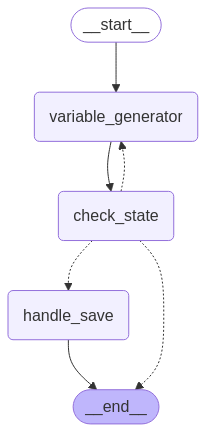

In [203]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [204]:
import uuid
config = {"configurable": {"thread_id": str(uuid.uuid4())}}


def run_client(docs: pd.DataFrame, DATABASE_URL:  str, config=config) -> OutputState:
    print("### Start Client ###\n")

    print(f"### Number of annonser: {len(docs)} ###")
    state = InputState(
        sql_engine=DATABASE_URL,
        pages_to_do=docs,
        llm_model_name="gpt-4o-mini",
        data_path="",
    )

    response = graph.invoke(state, config)

    if answer := response.get("pages_done"):
        print("🙌", answer)
        return

    if error := response.get("error_message"):
        print("\n🙈", error)
    return response

In [205]:
response = run_client(docs, DATABASE_URL = "sqlite:///./test.db")

### Start Client ###

### Number of annonser: 1 ###
### Entering variable generator ###
Length of pages to do: 1
### Invoking variable generator ###


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Sentences: ['LLM Powered Autonomous Agents is a concept discussed by Lilian Weng.', 'The date of the article is June 23, 2023.', 'The estimated reading time for the article is 31 minutes.', 'Lilian Weng is the author of the article.', 'Building agents with LLM as its core controller is a cool concept.', 'Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer, and BabyAGI, serve as inspiring examples.', 'The potentiality of LLM extends beyond generating well-written copies, stories, essays, and programs.', 'LLM can be framed as a powerful general problem solver.', 'In a LLM-powered autonomous agent system, LLM functions as the agent’s brain.', 'The agent system is complemented by several key components: Planning, Memory, and Tool Use.', 'Planning involves subgoal and decomposition, allowing the agent to break down large tasks into smaller, manageable subgoals.', 'Reflection and refinement enable the agent to do self-criticism and self-reflection over past actions.', 'Short-term 

AttributeError: 'list' object has no attribute 'id'

In [ ]:
all_states = []
for state in graph.get_state_history(config):
    print(state)
    all_states.append(state)
    print("--")

StateSnapshot(values={'next_agent': '__end__', 'llm_model_name': 'gpt-4o-mini', 'pages_to_do': [], 'pages_done': [Sentences(id='3006aa4d-9772-40d5-a6ea-94537191a04a', sentences=['LLM Powered Autonomous Agents is a concept discussed by Lilian Weng.', 'The date of the article is June 23, 2023.', 'The estimated reading time for the article is 31 minutes.', 'Lilian Weng is the author of the article.', 'Building agents with LLM as its core controller is a cool concept.', 'Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer, and BabyAGI, serve as inspiring examples.', 'The potentiality of LLM extends beyond generating well-written copies, stories, essays, and programs.', 'LLM can be framed as a powerful general problem solver.', 'In a LLM-powered autonomous agent system, LLM functions as the agent’s brain.', 'Several key components complement LLM in the agent system.', 'Planning is one of the key components of the agent system.', 'Task decomposition allows the agent to break down 

In [ ]:
state_values = graph.get_state(config=config).values